In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import time

a

In [2]:
#constants in table
kb = 1.38065e-23 #J/K
Na = 6.02214e23 #molelces/mole
h = 6.626073e-34 #Js
hbar = 1.05456e-34 #Js
c = 299792458 #m/s
#N2
mN2 = 28.0134 #g/mol
sigN2 = 2
BN2 = 1.99824*h*c*100
lambN2 = 2359 * 100 * c #HP: Your vib frequency wasn't correct. Your value: 2330 * 100 * c
engN2 = -944.46 #kJ/mol #-0.359727 hartee

#H2
mH2 = 2.016 #g/mol
sigH2 = 2
BH2 = 60.853*h*c*100
lambH2 = 4401.21 * 100 * c
engH2 = -456.75 #kJ/mol

#NH3
mNH3 = 17.031
sigNH3 = 6
B1NH3 = 9.44430*h*c*100
B2NH3 = 9.44430*h*c*100
B3NH3 = 6.19600*h*c*100
lamb1NH3 = 3337 *100 *c
lamb2NH3 = 950 * 100 * c
lamb3NH3 = 3444 * 100 * c
lamb4NH3 = 1627 * 100 * c
engNH3 = -1243.44 #kJ/mol #-0.473602

b) keq = fNH3 / ((fN2)**0.5 * (fH2)**1.5) where fi = Zi/V

c

In [3]:
#trans part func
def transfunc(temp):
    zN2 = (((2 * np.pi * (mN2/(1000*Na)) * kb * temp)**.5)/h)**3 
    zH2 = (((2 * np.pi * (mH2/(1000*Na)) * kb * temp)**.5)/h)**3
    zNH3 = (((2 * np.pi * (mNH3/(1000*Na)) * kb * temp)**.5)/h)**3 
    ktrans = (zNH3 / (((zN2)**.5) * ((zH2)**1.5))) * 6.022e26
    return ktrans

In [4]:
trial800 = transfunc(1150) #1.68e-4
print(trial800)

9.793228354447103e-05


In [5]:
#rot part func
def rotfunc(temp):
    zN2 = (kb * temp)/(sigN2 * BN2)
    zH2 = (kb * temp)/(sigH2 * BH2)
    zNH3 = (((np.pi)**.5)/sigNH3) * ((((kb * temp)**3)/(B1NH3 * B2NH3 * B3NH3))**.5)
    krot = zNH3 / (((zN2)**.5) * ((zH2)**1.5))
    return krot

In [6]:
trialrot800 = rotfunc(1150) #1.43
print(trialrot800)

1.1930338160481522


In [7]:
#vib part func
def vibfunc(temp):
    vibTN2 = (h * lambN2)/kb
    vibTH2 = (h * lambH2)/kb
    vib1TNH3 = (h * lamb1NH3)/kb
    vib2TNH3 = (h * lamb2NH3)/kb
    vib3TNH3 = (h * lamb3NH3)/kb
    vib4TNH3 = (h * lamb4NH3)/kb
    zN2 = (np.exp(-1 * vibTN2/(2 * temp)))/(1 - np.exp(-vibTN2/temp))
    zH2 = (np.exp(-1 * vibTH2/(2 * temp)))/(1 - np.exp(-vibTH2/temp))
    # HP: Here I squared two of the vibrational partition functions to account degeneracies.
    zNH3 =((np.exp(-1 * vib1TNH3/(2 * temp)))/(1 - np.exp(-vib1TNH3/temp)))    \
            * ((np.exp(-vib2TNH3/(2 * temp)))/(1 - np.exp(-vib2TNH3/temp)))    \
            *((np.exp(-vib3TNH3/(2 * temp)))/(1 - np.exp(-vib3TNH3/temp)))**2  \
            * ((np.exp(-vib4TNH3/(2 * temp)))/(1 - np.exp(-vib4TNH3/temp)))**2
    kvib = zNH3 / (((zN2)**.5) * ((zH2)**1.5)) #/ 100 # HP: Not sure why you divided by 100 here.
    return kvib

In [8]:
trialvib800 = vibfunc(800) #0.00345021
print(trialvib800)

0.003451201208234229


In [9]:
#elec part func
def elecfunc(temp):
    zN2 = np.exp((-1 * engN2*1000) /(kb * temp * Na))
    zH2 = np.exp((-1 * engH2*1000) /(kb * temp * Na))
    zNH3 = np.exp((-1 * engNH3*1000) /(kb * temp * Na))
    kelec = zNH3 / (((zN2)**.5) * ((zH2)**1.5))
    return kelec

In [10]:
trialelec800 = elecfunc(1150) #417255.19369101
print(trialelec800)

8128.768988230265


In [11]:
def partfunct(temp):
    ztrans = transfunc(temp)
    zrot = rotfunc(temp)
    zvib = vibfunc(temp)
    zelec = elecfunc(temp)
    keq = ztrans * zrot * zvib * zelec
    logkeq = np.log10(keq)
    return logkeq

d

In [12]:
def haber(temp):
    logkeq = 2.1 + (2098/temp) - 2.5088*np.log10(temp) - 1.006e-4*temp + 1.86e-7*(temp**2) + np.log10(0.0821*temp)
    return logkeq

In [13]:
#array with 800 - 1200K
temparray = np.arange(800, 1200, 1)
partfuncarray = partfunct(temparray)
haberarray = haber(temparray)

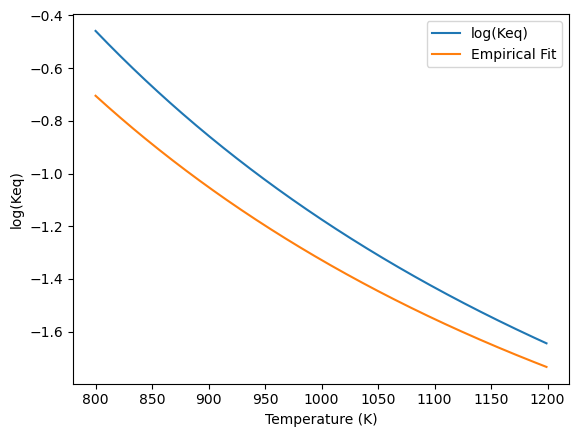

In [14]:
fig, ax = plt.subplots()
ax.plot(temparray, partfuncarray, label = 'log(Keq)')
ax.plot(temparray, haberarray, label = 'Empirical Fit')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('log(Keq)')
ax.legend()

plt.show()

e) Two possible reasons there a differences between the calculated and the experimental 
equilibrium constants could be due to the rotational partition function and our assumption of the high-temperature approximation (switching that summation to an integral in the derivation). NH3 also has relatively low rotational constants (at least compared to hydrogen) which may mean that we can't make that assumption or that may be one of the reasons why there are differences.

I would guess there are also differences due being higher than the vibrational temperature for some of the vibrational frequencies. If this is the case, at higher temperatures our Zvib = (kb * temp)/(h * omega) not the equation we used previously. This could also cause the differences. 